In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2


#data load & train/test split

In [3]:
# 경로 이동
import os
os.chdir('/content/drive/MyDrive/dacon_keypoint_data')

In [38]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
from albumentations.pytorch.transforms import ToTensor
from matplotlib import pyplot as plt

In [8]:
train = pd.read_csv('train_df.csv')
submission = pd.read_csv('sample_submission.csv')

In [11]:
# train_paths = glob.glob("/content/drive/My Drive/1. open/train_imgs/*.jpg")
# google colab에서는 "train_imgs" 폴더 안의 순서가 뒤엉킴

train_paths = []

for i in range(len(train)):
    val = train.image.values[i]
    image_path = f"train_imgs/{val}"
    train_paths.append(image_path)


#glob를 활용해 이미지의 경로들을 불러옵니다.

import glob

test_paths = glob.glob('test_imgs/*.jpg')
print(len(train_paths), len(test_paths))

4195 1600


In [14]:
train_paths[:3]

['train_imgs/001-1-1-01-Z17_A-0000001.jpg',
 'train_imgs/001-1-1-01-Z17_A-0000003.jpg',
 'train_imgs/001-1-1-01-Z17_A-0000005.jpg']

In [15]:
test_paths[:3]

['test_imgs/714-3-5-35-Z94_D-0000015.jpg',
 'test_imgs/714-3-5-35-Z94_D-0000013.jpg',
 'test_imgs/714-3-5-35-Z94_C-0000031.jpg']

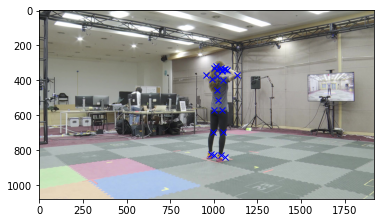

In [22]:
img_sample_path = train_paths[0]
img = Image.open(img_sample_path)
img_np = np.array(img)

keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
keypoint_sample = keypoint.iloc[0, :]
    
for j in range(0,len(keypoint.columns),2):
    plt.plot(keypoint_sample[j], keypoint_sample[j+1],'bx')
    plt.imshow(img_np)
    


In [24]:
img_np.shape

(1080, 1920, 3)

In [27]:
img_sample_path

'train_imgs/001-1-1-01-Z17_A-0000001.jpg'

#TorchVision augmentation

In [23]:
class TorchvisionDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with PIL
        image = Image.open(file_path)
        
        start_t = time.time()
        if self.transform:
            image = self.transform(image)
        total_time = (time.time() - start_t)

        return image, label, total_time

In [28]:
torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionDataset(
    file_paths=[img_sample_path],
    labels=[1],
    transform=torchvision_transform,
)

In [29]:
torchvision_dataset

torchvision time/sample: 44.06402111053467 ms


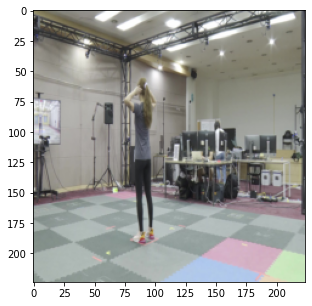

In [32]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time/sample: {} ms".format(total_time*10))

plt.figure(figsize=(5, 5))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()

# albumentation augmentation

In [36]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        start_t = time.time()
        if self.transform:
              augmented = self.transform(image=image) 
              image = augmented['image']
              total_time = (time.time() - start_t)
        return image, label, total_time

In [39]:
albumentations_transform = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(224, 224),
    albumentations.HorizontalFlip(), # Same with transforms.RandomHorizontalFlip()
    albumentations.pytorch.transforms.ToTensor()
])


albumentations time/sample: 2.1774792671203613 ms


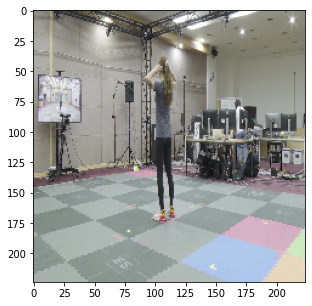

In [42]:
albumentations_dataset = AlbumentationsDataset(
    file_paths=[img_sample_path],
    labels=[1],
    transform=albumentations_transform,
)
total_time = 0
for i in range(100):
  sample, _, transform_time = albumentations_dataset[0]
  total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

plt.figure(figsize=(5, 5))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()

# various albumentation

In [43]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(256, 256), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

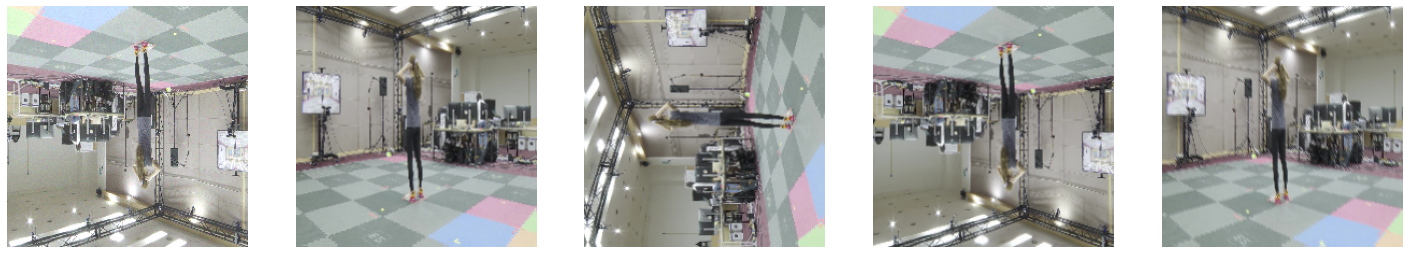

In [44]:
albumentations_dataset = AlbumentationsDataset(
    file_paths=[img_sample_path],
    labels=[1],
    transform=albumentations_transform_oneof,
)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentations_dataset[0][0]))
  ax[i].axis('off')